# Import library

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image

from sklearn.metrics import confusion_matrix

# Load dataset

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
def data_augmentation(rot=25, crop=True, hflip=True, vflip=True):
    transform_list = []
    # if rot:
    #     transform_list.append(transforms.RandomRotation(rot))
    # if hflip:
    #     transform_list.append(transforms.RandomHorizontalFlip())
    # if vflip:
    #     transform_list.append(transforms.RandomVerticalFlip())

    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))

    return transforms.Compose(transform_list)

In [4]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        data = csv_file.values
        self.labels = data[:, 0]
        self.images = data[:, 1:].reshape(-1, 28, 28).astype(np.uint8)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]
        image = Image.fromarray(image)  # Convert numpy to PIL

        if self.transform:
            image = self.transform(image)

        return image, label

# Load data from csv
from torch.utils.data import random_split


train_csv = pd.read_csv("../data/fashion-mnist_train.csv")
test_csv = pd.read_csv("../data/fashion-mnist_test.csv")
train_set = FashionMNISTDataset(train_csv, transform = data_augmentation())
test_set = FashionMNISTDataset(test_csv, transform =  data_augmentation())
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 32, shuffle=True)

print("Train set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

Train set size: 48000
Validation set size: 12000
Test set size: 10000


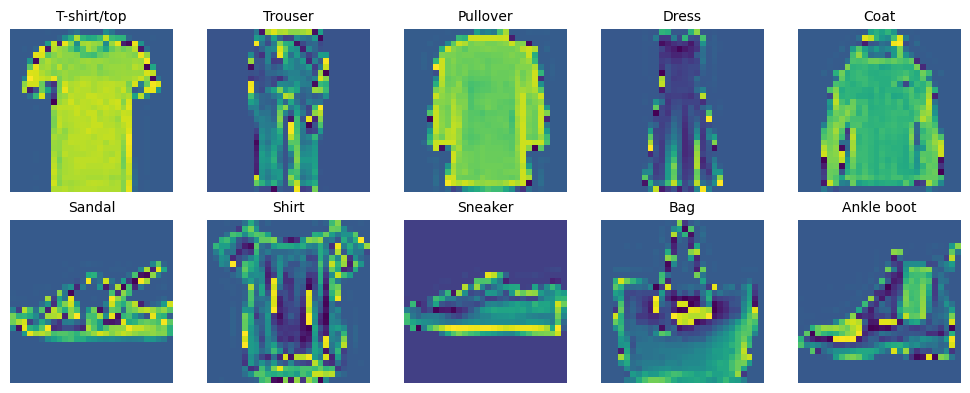

In [5]:
#class mapping
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

def show_one_per_class(dataset, class_names=None, num_classes=None, rows=2, cols=5):

    seen = {}
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    for idx in indices:
        _, label = dataset[idx]
        label = int(label)
        if label not in seen:
            seen[label] = idx
        if num_classes and len(seen) >= num_classes:
            break

    # Sort the labels for consistent display
    sorted_items = sorted(seen.items(), key=lambda x: x[0])
    total = len(sorted_items)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i, (label, idx) in enumerate(sorted_items):
        image, _ = dataset[idx]

        if isinstance(image, torch.Tensor):
            image = image.clone()
            image = image * 0.5 + 0.5  # unnormalize if needed
            image = to_pil_image(image)

        axes[i].imshow(image)
        axes[i].set_title(class_names[label] if class_names else f"Class {label}", fontsize=10)
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

show_one_per_class(train_set, list(class_names.values()))

# Model summary
* 5 convolutional blocks (ending with 512 feature maps and 7x7 spatial size)
* 2 fully connected blocks of size 4096
* Final output layer to 10 classes

In [6]:
class DNNv2(nn.Module):
    def __init__(self):
        super(DNNv2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # 28x28 → 28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 28x28 → 28x28
        self.pool = nn.MaxPool2d(2, 2)                            # 28x28 → 14x14
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 14x14 → 14x14
        self.pool2 = nn.MaxPool2d(2, 2)                           # 14x14 → 7x7
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = x.view(-1, 128 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define Hyper parameters


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = DNNv2()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
epoch = 25 # Was set by many trials -> Descent performance in train/test but not overfitted
model.to(device)

cpu


DNNv2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

# Training

In [8]:
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
for epochs in range(epoch):
    loss_ep = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Epoch {epochs+1} ] Loss : {loss_ep/len(train_loader):.6f}")

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)
            ## Forward Pass
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(f"Epoch {epochs+1} ] Validation Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%")

Epoch 1 ] Loss : 0.579674
Epoch 1 ] Validation Accuracy : 85.20%
Epoch 2 ] Loss : 0.368189
Epoch 2 ] Validation Accuracy : 87.72%
Epoch 3 ] Loss : 0.316673
Epoch 3 ] Validation Accuracy : 88.86%
Epoch 4 ] Loss : 0.285522
Epoch 4 ] Validation Accuracy : 89.88%
Epoch 5 ] Loss : 0.257861
Epoch 5 ] Validation Accuracy : 90.41%
Epoch 6 ] Loss : 0.233908
Epoch 6 ] Validation Accuracy : 90.36%
Epoch 7 ] Loss : 0.216789
Epoch 7 ] Validation Accuracy : 90.52%
Epoch 8 ] Loss : 0.202863
Epoch 8 ] Validation Accuracy : 91.57%
Epoch 9 ] Loss : 0.187154
Epoch 9 ] Validation Accuracy : 91.51%
Epoch 10 ] Loss : 0.172785
Epoch 10 ] Validation Accuracy : 92.09%
Epoch 11 ] Loss : 0.160794
Epoch 11 ] Validation Accuracy : 92.26%
Epoch 12 ] Loss : 0.149237
Epoch 12 ] Validation Accuracy : 92.05%
Epoch 13 ] Loss : 0.139785
Epoch 13 ] Validation Accuracy : 92.51%
Epoch 14 ] Loss : 0.128828
Epoch 14 ] Validation Accuracy : 92.07%
Epoch 15 ] Loss : 0.119977
Epoch 15 ] Validation Accuracy : 92.39%
Epoch 16 ] Lo

#Test

In [9]:
model.eval()
correct = total = 0

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(test_loader):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        scores = model(data)
        _, predictions = scores.max(1)
        correct += (predictions == targets).sum().item()
        total += targets.size(0)

print(f"Test Accuracy: {correct / total * 100:.2f}%")

Test Accuracy: 93.52%


#Evaluation Metrics

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import torch.nn.functional as F
import numpy as np

all_preds = []
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(data)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

###Confusion Matrix

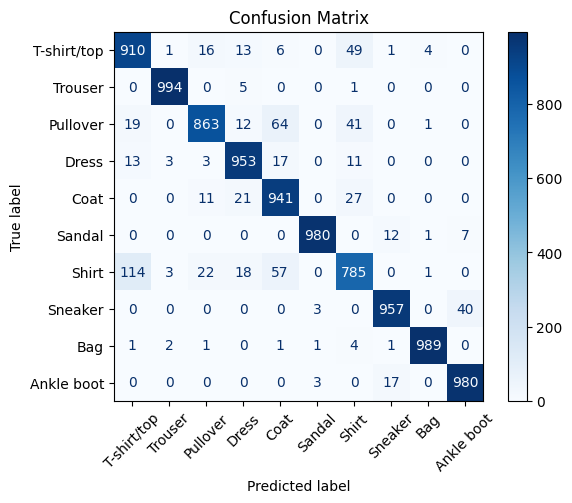

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_names.values()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

### Precision, Recall, F1-score (per class)

In [12]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(class_names.values())))

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.91      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.94      0.86      0.90      1000
       Dress       0.93      0.95      0.94      1000
        Coat       0.87      0.94      0.90      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.86      0.79      0.82      1000
     Sneaker       0.97      0.96      0.96      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.95      0.98      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.93     10000
weighted avg       0.94      0.94      0.93     10000



###Top-k Accuracy, k = 3

In [13]:
topk = 3
topk_correct = 0
total = 0

model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(data)
        _, topk_preds = outputs.topk(topk, dim=1)  # [batch, topk]
        match = topk_preds.eq(labels.view(-1, 1))  # [batch, topk]

        topk_correct += match.any(dim=1).sum().item()
        total += labels.size(0)

topk_acc = topk_correct / total * 100
print(f"Top-{topk} Accuracy: {topk_acc:.2f}%")

Top-3 Accuracy: 99.58%


###ROC-AUC / PR-AUC

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# One-hot encode labels
y_true_bin = label_binarize(all_labels, classes=list(range(10)))
roc_auc = roc_auc_score(y_true_bin, all_probs, average="macro", multi_class="ovr")
print(f"Multiclass ROC-AUC (macro avg): {roc_auc:.4f}")

Multiclass ROC-AUC (macro avg): 0.9967
